In [1]:
import os
import shutil
import json
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
import numpy as np
import pandas as pd
import time
import shutil
import math
import pathlib
import sys


from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.restoration import denoise_tv_chambolle
import cv2
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchsummary as summary

import tensorflow as tf
import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import keras.backend as K

plt.ion()
from IPython.display import clear_output

In [2]:
root = './scan_doc_rotation/'         
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')

In [3]:
test_list_path = os.path.join(root, 'test_list.json')   

with open(test_list_path) as f:
    test_list = json.load(f)     

In [4]:
train_list_path = os.path.join(root, 'train_list.json')

with open(train_list_path) as f:
    train_list = json.load(f)   

label_list = [x.split('.')[0] + '.txt' for x in train_list]     

In [5]:
def get_random_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(image_paths, train_list[id])
    sample_label_path = os.path.join(label_paths, label_list[id])
    return id, sample_image_path, sample_label_path

In [6]:
def display_image(path=None, img=None):
    if path is not None:
        img = Image.open(path)

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray');

ID of document is : 374
Rotation angle is : 3.092133553658522


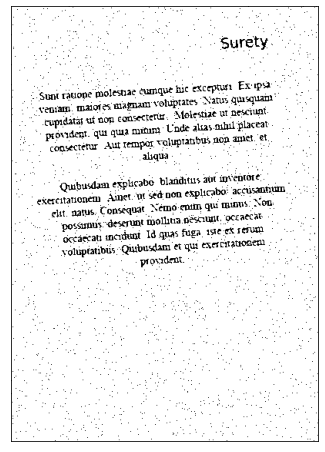

In [10]:
id, sample_image_path, sample_label_path = get_random_img()

display_image(path=sample_image_path)

with open(sample_label_path) as f:
    angle = f.read()
print('ID of document is :', id)
print('Rotation angle is :', angle)

In [11]:
def display_image_grid(images, n=10, angles=None):
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111,  
                    nrows_ncols=(n, n),  
                    axes_pad=0.25, 
                    )

    i = 0
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap='gray');
        ax.set_xticks([])
        ax.set_yticks([])
        if angles is not None:
            angle = angles[i] - 5
            ax.set_title(label=str(angle))
        i += 1

    plt.show()

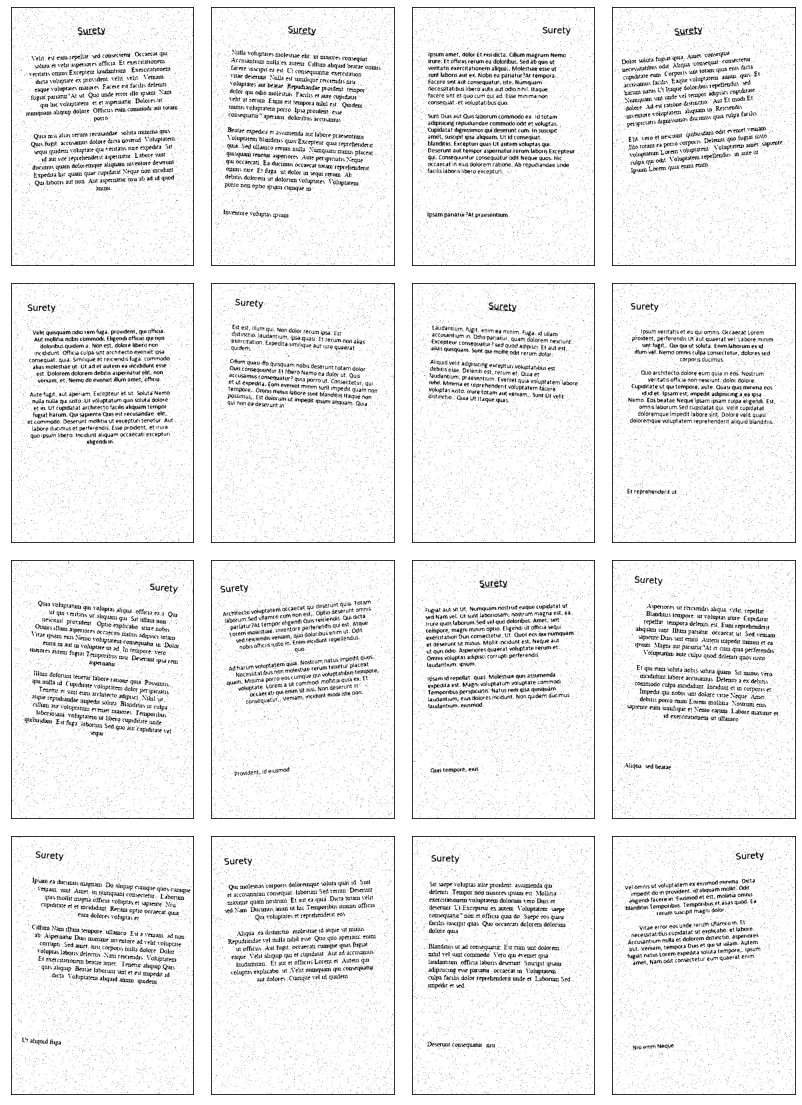

In [14]:
sampled_images = []
sampled_ids = []

for i in range(16):
    id, sample_image_path, sample_label_path = get_random_img()
    if id not in sampled_ids:
        img = Image.open(sample_image_path)
        sampled_ids.append(id)
        sampled_images.append(img)

display_image_grid(sampled_images, 4)

In [15]:
def denoise(img, to_PIL=True):
    img = denoise_tv_chambolle(img, weight=0.5, multichannel=0)
    if to_PIL:
        Image.fromarray(img)
    return img

<ipython-input-15-da4af87077a0>:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=0.5, multichannel=0)


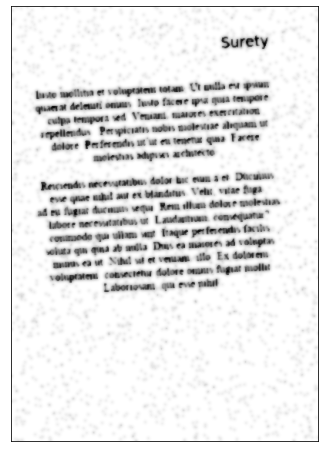

In [16]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)

img = denoise(img)
display_image(img=img)

In [17]:
def fft(img, to_PIL=True):
    f = cv2.dft(np.float32(img))    # Discrete Fourier transform
    fshift = np.fft.fftshift(f)     # Shift the zero-frequency component to the center of the spectrum
    f_abs = np.abs(fshift) + 1.0    # shift to ensure no zeroes are present in image array
    f_img = 20 * np.log(f_abs)      # final result
    if to_PIL:
        return Image.fromarray(f_img)
    return f_img

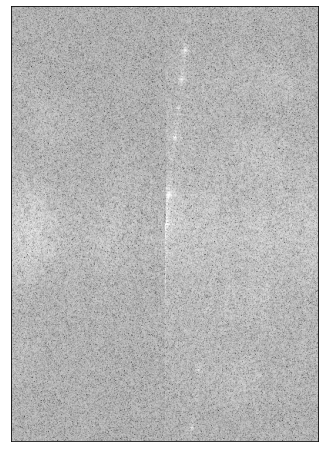

In [18]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)
# img = cv2.imread(sample_image_path)
# img = img[:,:,0]

f_img = fft(img)
display_image(img=f_img)

In [19]:
def preprocess(img):
    return fft(denoise(img))

<ipython-input-15-da4af87077a0>:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=0.5, multichannel=0)


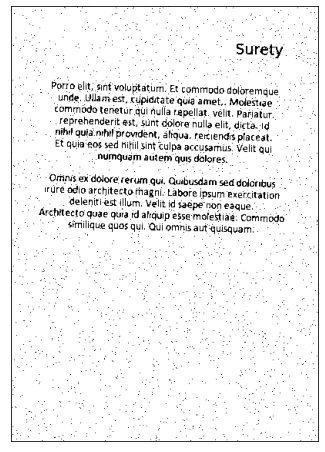

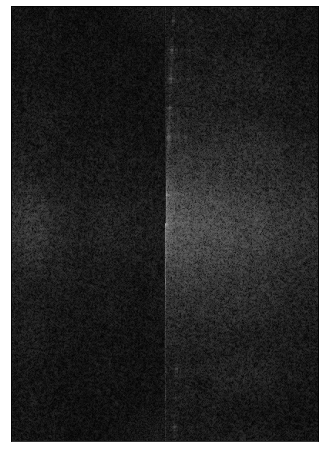

In [20]:
id, sample_image_path, sample_label_path = get_random_img()
img = cv2.imread(sample_image_path)
img = img[:,:,0]

f_img = preprocess(img)
display_image(img=img)
display_image(img=f_img)

In [21]:
prep_image_paths = os.path.join(root, 'preprocessed images') 
os.mkdir(prep_image_paths)

for img_name in os.listdir(image_paths):
    img_src_path = os.path.join(image_paths, img_name)
    img = Image.open(img_src_path)
    img = np.array(img)
    img = preprocess(img)
    
    img = np.array(img)
    img = Image.fromarray((img).astype(np.uint8))
    img_dst_path = os.path.join(prep_image_paths, img_name)
    img.save(img_dst_path)

<ipython-input-15-da4af87077a0>:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=0.5, multichannel=0)


In [22]:
labels = {}
for textfile in label_list:
    path = os.path.join(label_paths, textfile)
    with open(path) as f:
        label = float(f.read())
    file_name = textfile.split('.')[0]
    labels[file_name] = round(label)

In [23]:
labels['scan_000'], labels['scan_010'], labels['scan_499']

(0, -3, -1)

In [24]:
df = pd.DataFrame(data={'name':labels.keys(), 'label':labels.values()})
df['categorical label'] = df['label'] + 5
df['categorical label'] = df['categorical label'].astype('int').astype('category')

In [25]:
df.head()

name  label categorical label
0  scan_000      0                 5
1  scan_001     -2                 3
2  scan_002     -5                 0
3  scan_003     -5                 0
4  scan_004     -1                 4

In [26]:
df_train, df_val = train_test_split(df, test_size=0.2)
df_train.shape, df_val.shape

((400, 3), (100, 3))

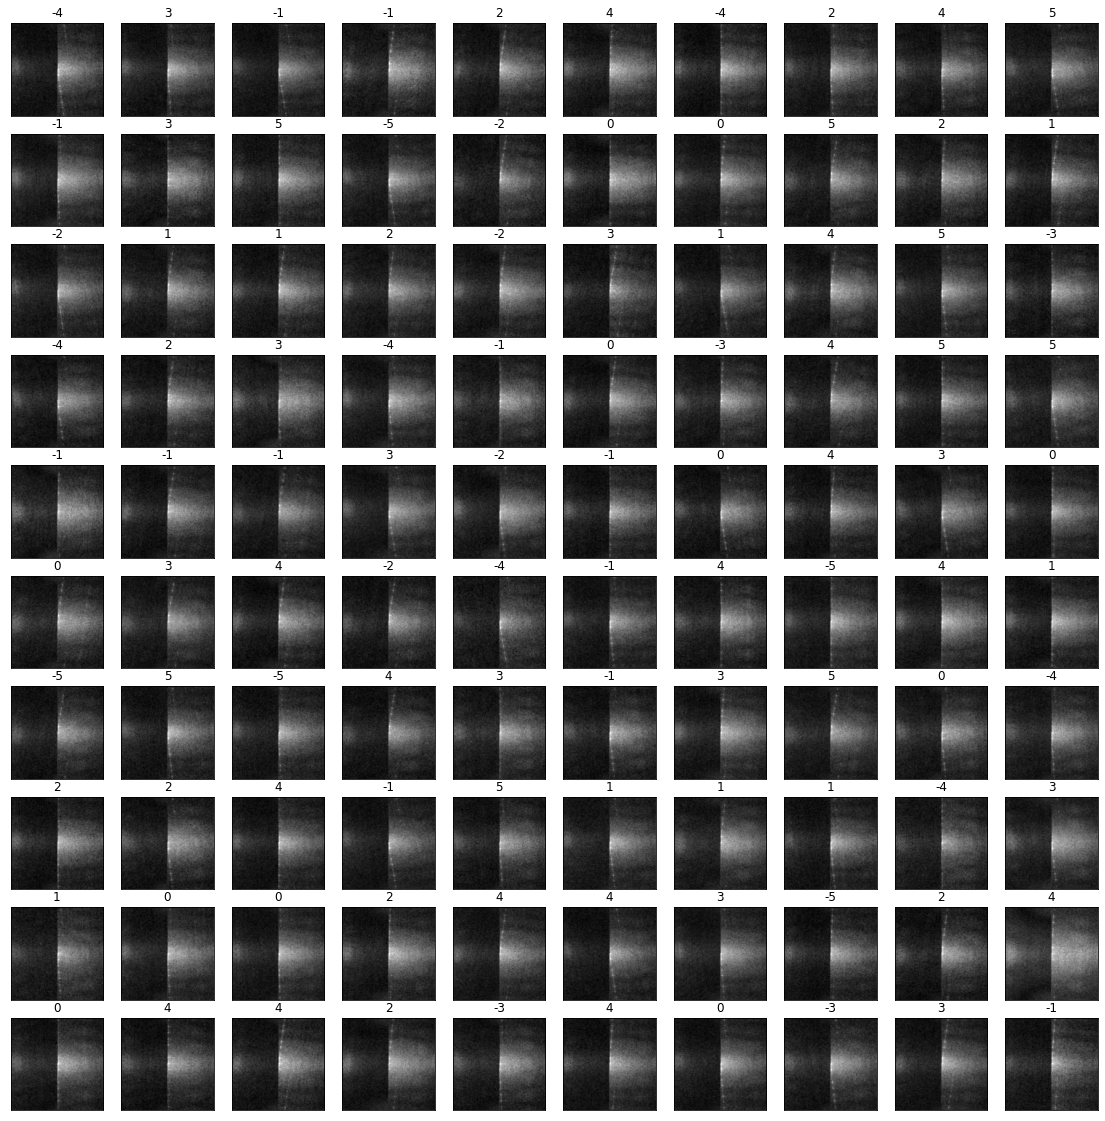

In [31]:
sampled_images = []
sampled_labels = []
sampled_ids = []

sampled_ids = random.sample(list(range(400)), 100)
sampled_images = [train_dataset[i][0].squeeze().cpu().detach().numpy() for i in sampled_ids]
sampled_labels = [train_dataset[i][1] for i in sampled_ids]

display_image_grid(sampled_images, 10, sampled_labels)

# Creating a ROTNET

In [32]:
!git clone https://github.com/d4nst/RotNet.git

Cloning into 'RotNet'...


In [35]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "./RotNet/utils.py", dst = "./my_functions.py")

# import all our functions
from my_functions import *

In [36]:
 #Getting image names and labels and saving them in "labels" dictionary 
labels = {}
for textfile in label_list:
    path = os.path.join(label_paths, textfile)
    with open(path) as f:
        label = float(f.read())
    file_name = textfile.split('.')[0]
    labels[file_name] = label

In [37]:
# Creating new images by rotating them 
new_images = []
new_labels = []
for image_id, angle in labels.items():
    image_path = os.path.join(image_paths, image_id+'.png')
    img = Image.open(image_path)                                # open image as PIL Image
    img = np.array(img)                                         # convert PIL Image to np array
    corrected_img = rotate(img, -angle)                         # rotate image to get corrected image
    
    sample_angles = random.sample(range(-45, 45), 50)           # sample 50 numbers between -45 to 45
    for sample_angle in sample_angles:
        new_img = generate_rotated_image(corrected_img,         # generate a valid rotated image based on sample_angle and
                                        sample_angle,          #     it resize image to 64*64
                                        size=(128, 128),
                                        crop_center=True,
                                        crop_largest_rect=True)
        new_images.append(new_img)
        new_labels.append(sample_angle)

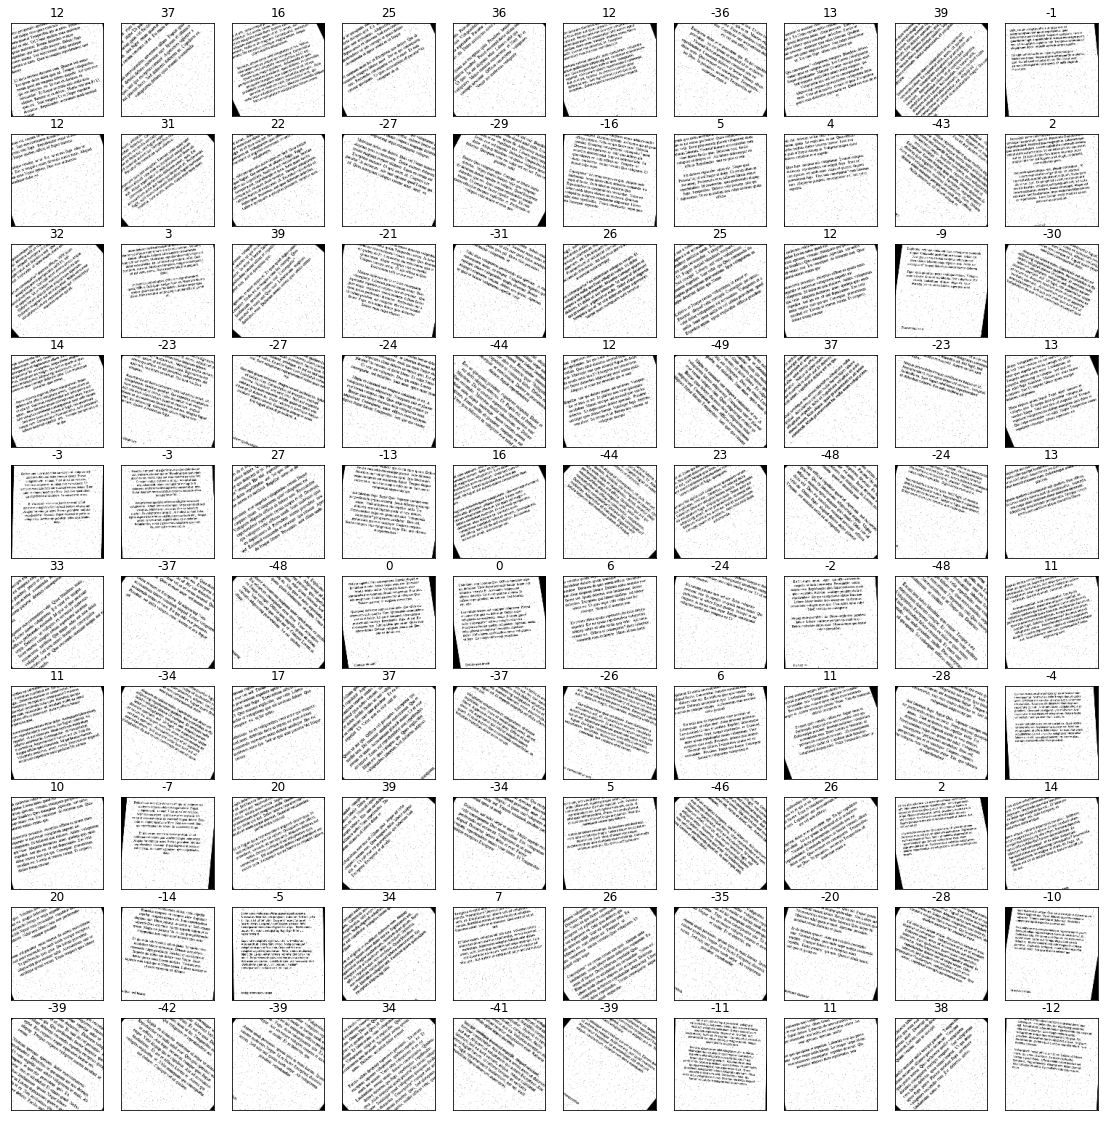

In [38]:
# N is number of all images in dataset
N = len(new_images)

# Sampling 100 images to display
sampled_image_indecies = random.sample(range(N), 100)
sampled_images = [Image.fromarray(new_images[i]) for i in sampled_image_indecies]
sampled_labels = [new_labels[i] for i in sampled_image_indecies]

# Displays 10*10 grid of rotated images from new dataset. The number in above of each image, is rotated angle
display_image_grid(sampled_images, 10, sampled_labels)

In [39]:
nb_classes = np.unique(new_labels).__len__()
data = np.stack(new_images, axis=0)                            # converting all images to a np array

X = data.copy()
Y = to_categorical(np.array(new_labels) + 45, nb_classes)       # creating categorical labels

X = X/255                                                      # move image values to [0, 1] period 
X = np.where(X > 0.5, 1, 0)                                    # binarize images with threshold=0.5

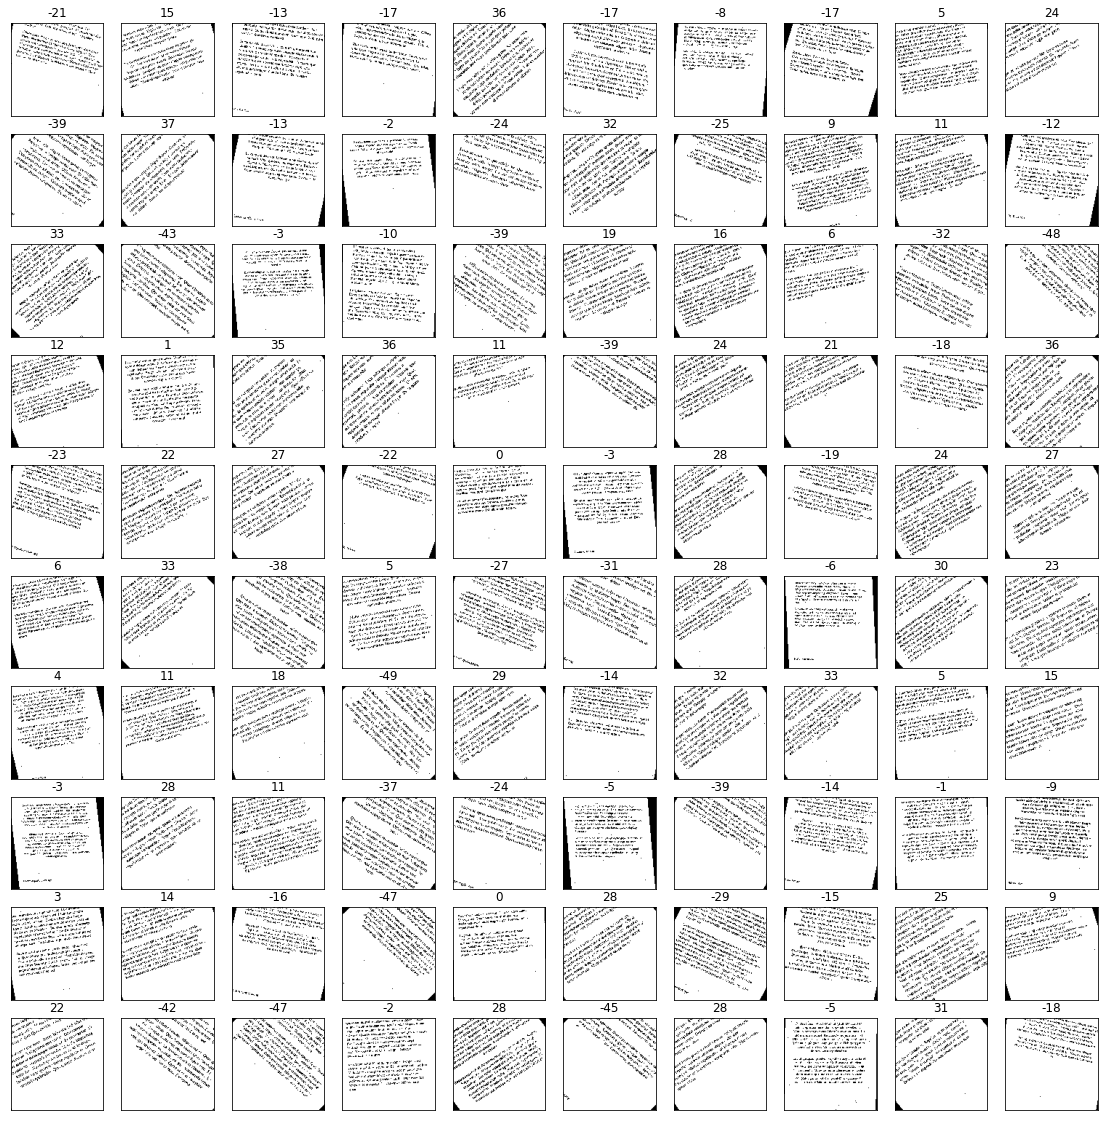

In [40]:
# Sample
sampled_image_indecies = random.sample(range(N), 100)
sampled_images = [Image.fromarray((X[i]*255).astype(np.uint8)) for i in sampled_image_indecies]
sampled_labels = [new_labels[i] for i in sampled_image_indecies]

display_image_grid(sampled_images, 10, sampled_labels)

In [41]:
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [42]:
nb_train_samples, img_height, img_width = X.shape
img_channels = 1
input_shape = (img_height, img_width, img_channels)

print('Input shape:', input_shape)
print(nb_train_samples, 'train samples')

Input shape: (128, 128, 1)
25000 train samples


In [43]:
# model definition
input = Input(shape=(img_height, img_width, img_channels))
x = Conv2D(nb_filters, kernel_size, activation='relu')(input)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                         

In [45]:
model.compile(loss='categorical_crossentropy',
            optimizer= tf.keras.optimizers.Adam(lr=5e-4),
            metrics=[angle_error, 'acc'])

In [46]:
batch_size = 128
nb_epoch = 30

In [47]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [48]:
tensorboard = TensorBoard()
plotlearning = PlotLearning()
early_stopping = EarlyStopping(patience=5)

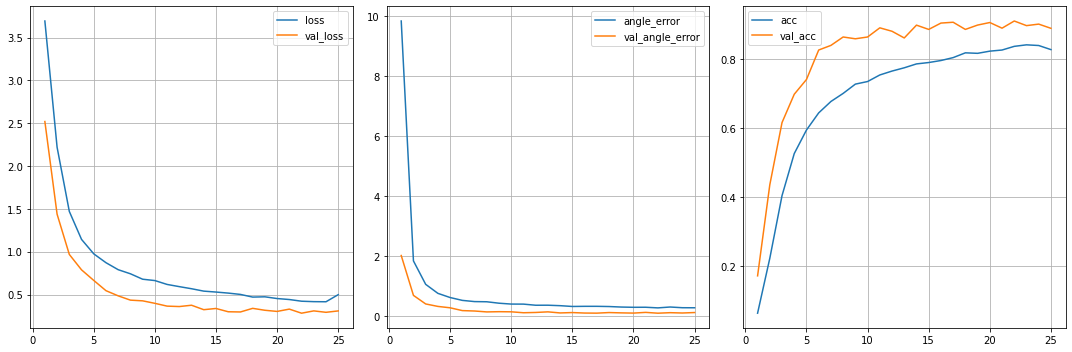

195/195 [==============================] - 55s 260ms/step - loss: 0.4985 - angle_error: 0.2760 - acc: 0.8274 - val_loss: 0.3087 - val_angle_error: 0.1168 - val_acc: 0.8892


In [49]:
model.fit(
    x = X,
    y = Y,
    batch_size=batch_size,
    steps_per_epoch=nb_train_samples / batch_size,
    epochs=nb_epoch,
    validation_split=0.2,
    verbose=1,
    callbacks=[tensorboard, plotlearning, early_stopping]
)

In [50]:
!mkdir -p saved_model
model.save('saved_model/rotnet')

INFO:tensorflow:Assets written to: saved_model/rotnet\assets


INFO:tensorflow:Assets written to: saved_model/rotnet\assets


In [51]:
model.save('rotnet.h5')

In [60]:
def angle_error():
    return angle_error

new_model = tf.keras.models.load_model('saved_model/rotnet',custom_objects={"angle_error":angle_error})
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                         

In [61]:
test_df = pd.DataFrame(data={'image':list(map(lambda x:x.split('.')[0], test_list)), 'label':np.zeros(len(test_list), int)})

In [62]:
# get images and convert them to array and add to test_images list
test_images = []
for image_name in test_df['image'].values:
    image_path = os.path.join(image_paths, image_name+'.png')
    img = Image.open(image_path)
    img = np.array(img)
    new_img = generate_rotated_image(img,
                                    0,
                                    size=(128, 128),
                                    crop_center=False,
                                    crop_largest_rect=False)
    test_images.append(new_img)

In [63]:
# preparing test data for model
X_test = np.stack(test_images)
X_test = X_test / 255
X_test = np.where(X_test > 0.5, 1, 0)

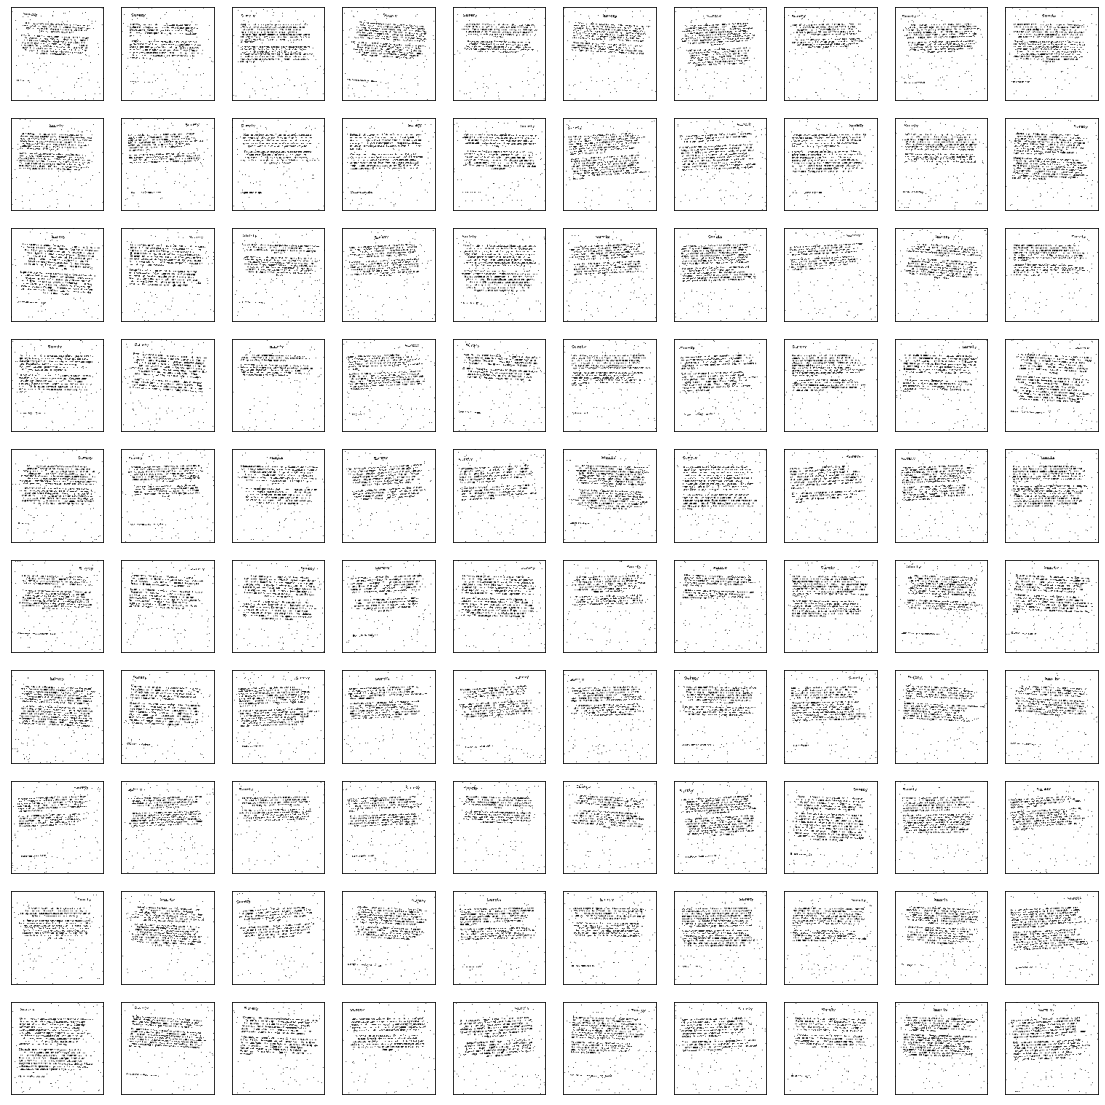

In [64]:
# display test images
display_image_grid(X_test, 10)

In [68]:
predicted_angles = np.argmax(new_model(X_test), axis=1) - 45

In [69]:
corrected_test_images = []

for i, image_name in enumerate(test_df['image'].values):
    image_path = os.path.join(image_paths, image_name+'.png')
    img = Image.open(image_path)
    img = np.array(img)
    angle = predicted_angles[i]
    corrected_img = rotate(img, -angle)
    corrected_test_images.append(corrected_img)

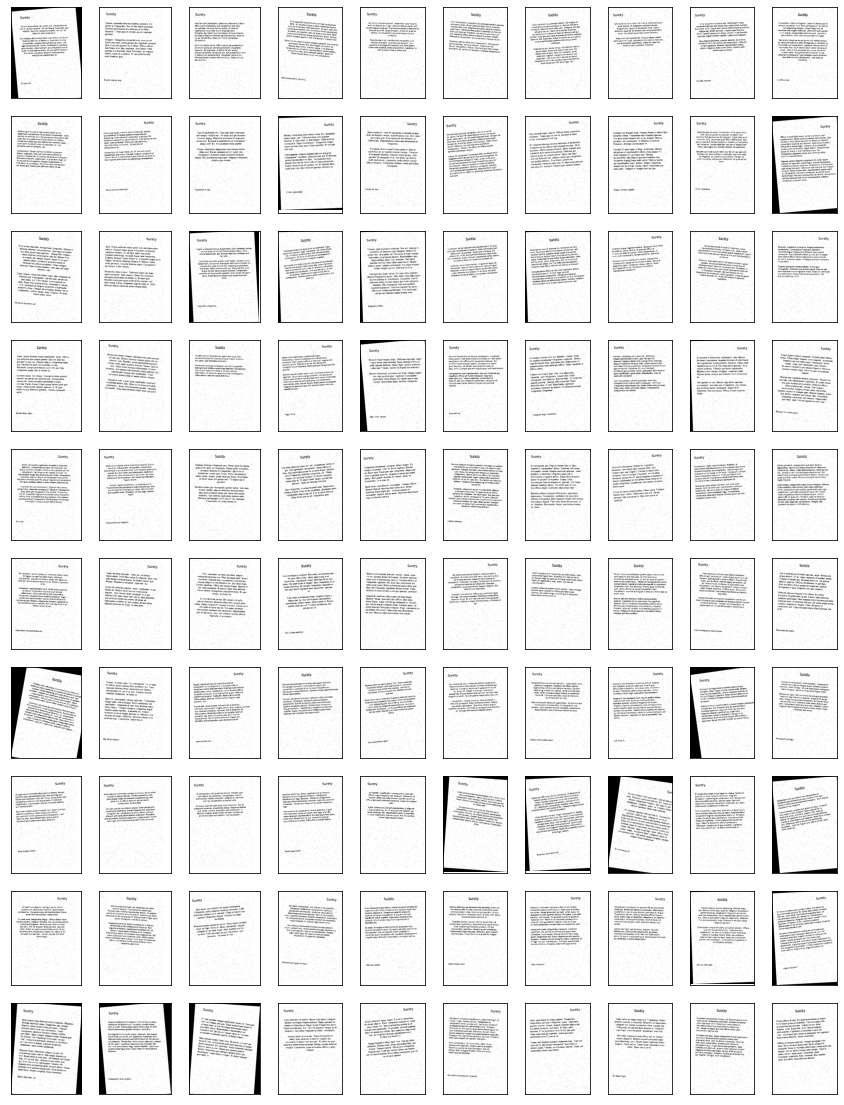

In [70]:
# display corrected test images
display_image_grid(corrected_test_images, 10)

In [72]:
def correct_image(model, img, threshold=0.6):
    img_arr = np.array(img)
    img_arr = generate_rotated_image(img_arr, 0, size=(128,128))
    img_arr = img_arr/255
    img_arr = np.where(img_arr > threshold, 1, 0)
    
    predicted_angle = np.argmax(model(img_arr[np.newaxis, ...])) - 45
    print(predicted_angle)
    new_image = rotate(np.array(img), -predicted_angle)
    return Image.fromarray(new_image)

11


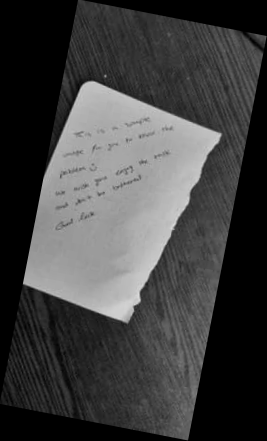

In [73]:
img = Image.open('./example.jpg').convert('L')
correct_image(model, img)